In [1]:
import numpy as np
from numpy import linalg as LA
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

# Question 1

In [3]:
all_des = []
sift = cv2.xfeatures2d.SIFT_create()
for foldername in os.listdir(os.getcwd()+'/50_ObjectCategories'):
    if os.path.isdir(os.getcwd()+'/50_ObjectCategories/'+foldername):
        for filename in os.listdir(os.getcwd()+'/50_ObjectCategories/'+foldername):
            if filename.endswith('.jpg'):
                img = cv2.imread(os.getcwd()+'/50_ObjectCategories/'+foldername+'/'+filename, 0)
                kp, des = sift.detectAndCompute(img,None)
                all_des += list(des[:100])
print len(all_des)


221164


In [4]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(np.array(all_des),50,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

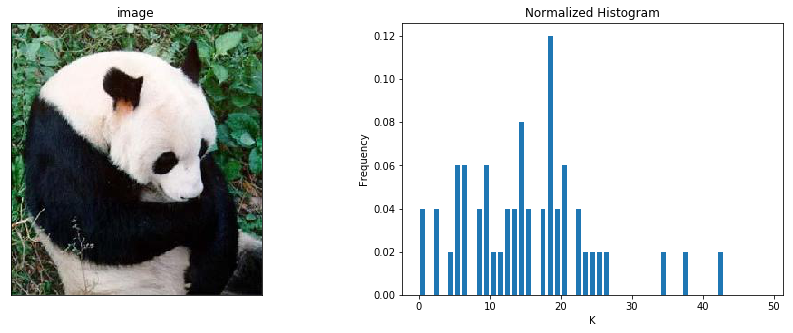

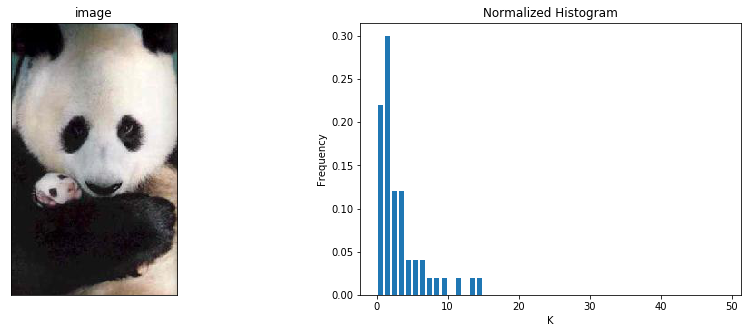

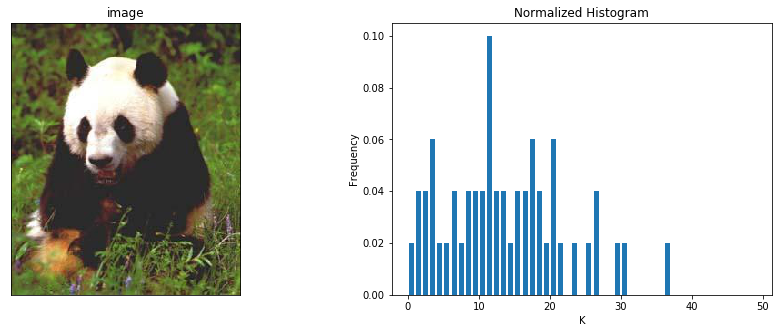

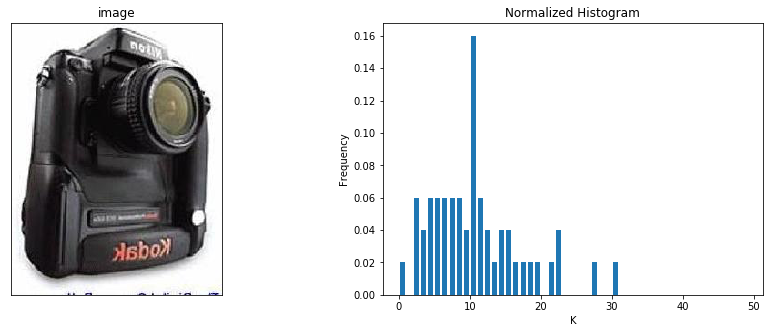

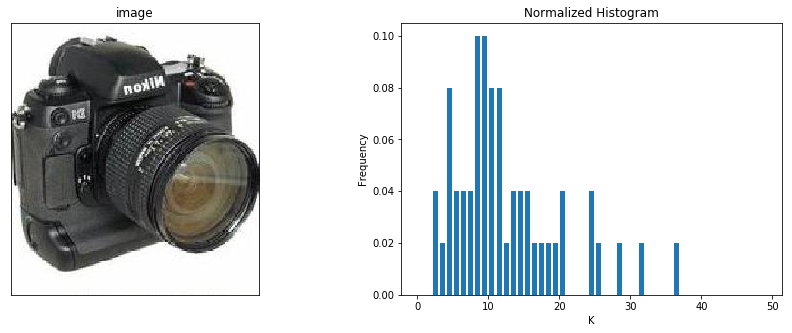

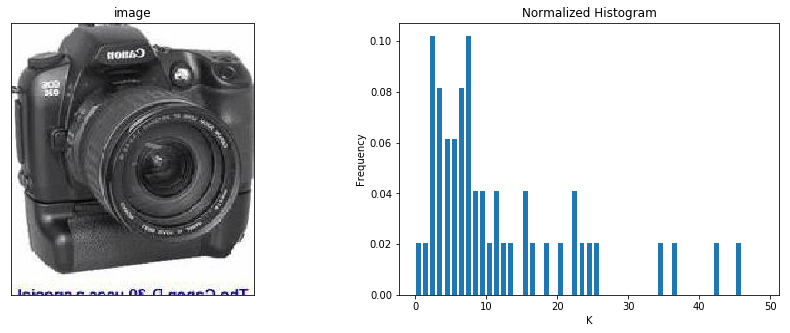

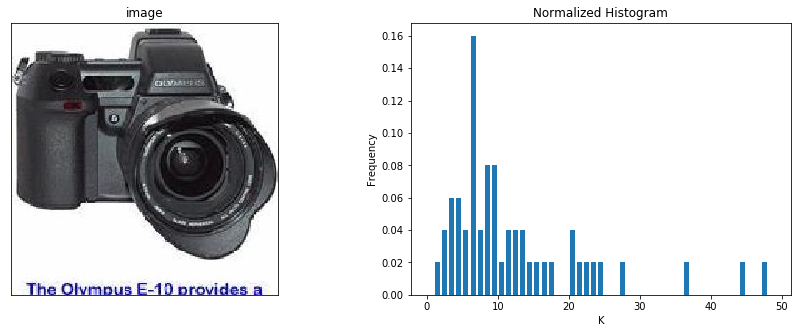

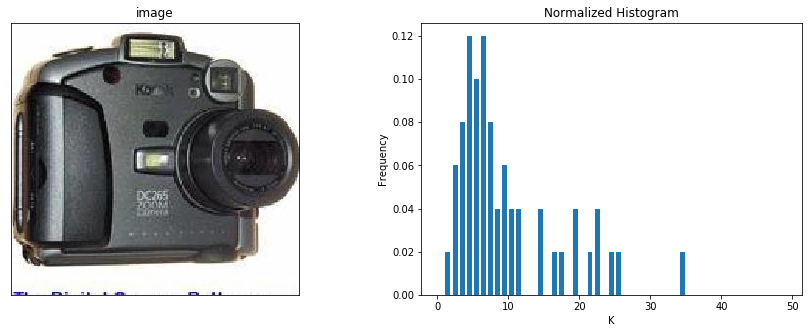

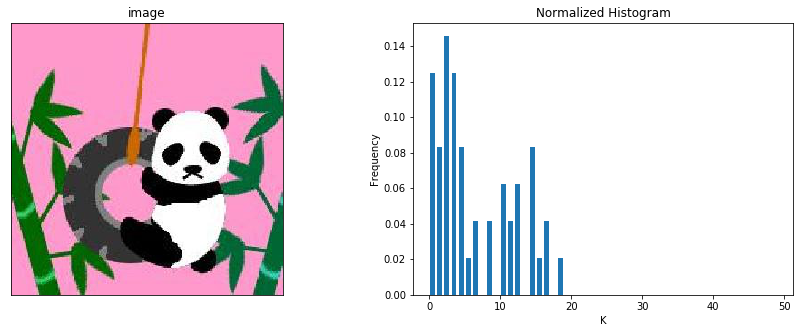

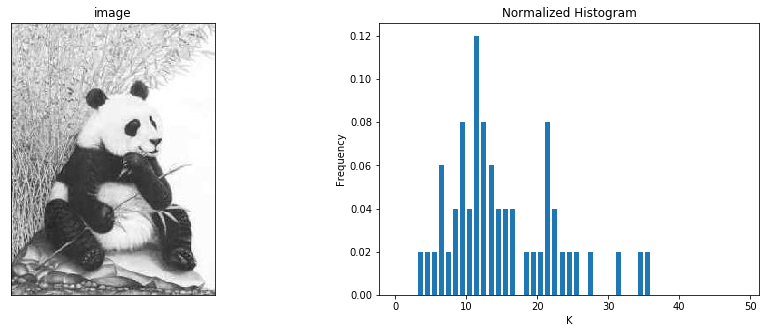

In [5]:
for filename in os.listdir(os.getcwd()+'/testing_img'):
    if filename.endswith('.jpg'):
        img = cv2.imread(os.getcwd()+'/testing_img/'+filename)
        kp, des = sift.detectAndCompute(img,None)
        hist = np.zeros(50)
        for d in des:
            distances = map(lambda c: np.linalg.norm(c-d), center)
            hist[np.argmin(distances)] += 1
        
        plt.figure(figsize=(15,5))
        plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('image')
        plt.xticks([]), plt.yticks([])
        plt.subplot(122), 
        plt.hist(hist,normed= True, rwidth=0.7, range=[0, 50], bins=range(0,50))
        plt.title("Normalized Histogram")
        plt.xlabel("K")
        plt.ylabel("Frequency")
        plt.show()        

# Question 2

In [26]:
img_before = cv2.imread('flow_images/frame1.jpg', 0)
img_after = cv2.imread('flow_images/frame2.jpg', 0)

# sobel x and y
sobel_x_without_padding = cv2.Sobel(img_before,cv2.CV_64F,1,0,ksize=3)
sobel_y_without_padding = cv2.Sobel(img_before,cv2.CV_64F,0,1,ksize=3)
diff_without_padding = img_after - img_before

sobel_x = cv2.copyMakeBorder(sobel_x_without_padding,7,7,7,7,cv2.BORDER_CONSTANT,value=0)
sobel_y = cv2.copyMakeBorder(sobel_y_without_padding,7,7,7,7,cv2.BORDER_CONSTANT,value=0)
diff = cv2.copyMakeBorder(diff_without_padding,7,7,7,7,cv2.BORDER_CONSTANT,value=0)

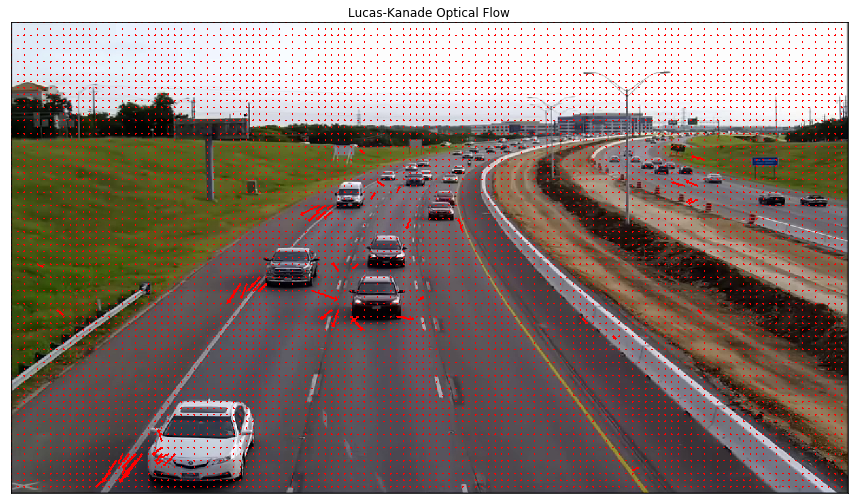

In [68]:
# calc and draw flow vector
img_result = cv2.imread('flow_images/frame2.jpg')
window_size = 15
flow_size = [img_before.shape[0]/window_size, img_before.shape[1]/window_size]
vectors = np.zeros((img_before.shape[0], img_before.shape[1], 2), dtype=float)
for row in xrange(img_before.shape[0]):
    sys.stdout.write('Analyzing row %d/%d  \r' % (row+1, img_before.shape[0]))
    sys.stdout.flush()
    for col in xrange(img_before.shape[1]):
        
        window_x_pos = row
        window_y_pos = col
        sobel_x_window = sobel_x[window_x_pos:window_x_pos+window_size, window_y_pos:window_y_pos+window_size]
        sobel_y_window = sobel_y[window_x_pos:window_x_pos+window_size, window_y_pos:window_y_pos+window_size]
        diff_window = diff[window_x_pos:window_x_pos+window_size, window_y_pos:window_y_pos+window_size]
        diff_window = np.array(diff_window).flatten().T
        
        At = np.array([sobel_x_window.flatten(), sobel_y_window.flatten()])
        A = At.T
        At_A = At.dot(A)
        w, u = np.linalg.eig(At_A)

        v = np.array([0, 0])
        if (w>6000).all() and np.linalg.det(At_A)>0:
            v = np.linalg.inv(At_A).dot(At).dot(diff_window)
            if (np.abs(v)<2).any():
                v = np.array([0, 0])

#             print v
        vectors[row, col, 0] = v[0]
        vectors[row, col, 1] = v[1]

for row in xrange(img_result.shape[0]/10):
    for col in xrange(img_result.shape[1]/10):
        cv2.arrowedLine(img_result,(col*10,row*10),(int(col*10+2*vectors[row*10, col*10, 0]),int(row*10+2*vectors[row*10, col*10, 1])),(0,0,255),2)
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)), plt.title('Lucas-Kanade Optical Flow')
plt.xticks([]), plt.yticks([])
plt.show()